4주차
===

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from PIL import Image as PILImage
from io import BytesIO

def notebook_dp_image(path: str, dim: set) -> None:
    img = PILImage.open(path)
    resized_img = img.resize(dim)  # (Width, Height)
    buffer = BytesIO()
    resized_img.save(buffer, format='PNG')
    display(Image(data=buffer.getvalue()))

_p106~146까지_

# 신경망 학습

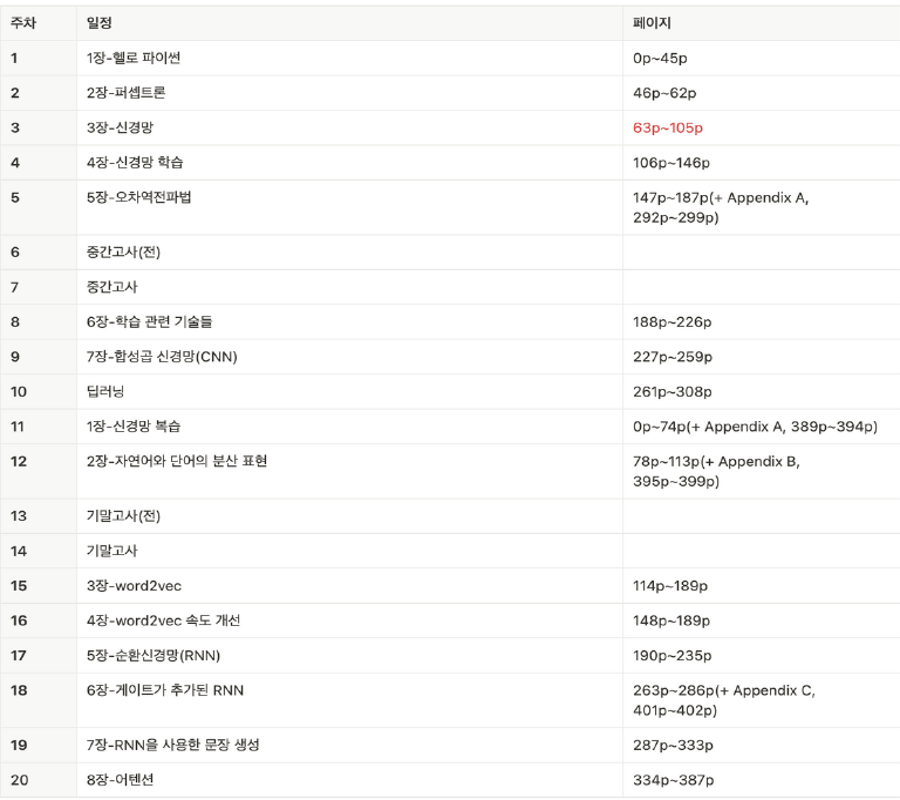

In [2]:
notebook_dp_image('./images/curriculum.png', (900,800))

---

### 데이터로만 학습하는 딥러닝

TLDR; 사람이 항상 개입하던 기존의 알고리즘 구현방식과 달리 딥러닝은 모델이 처음부터 끝까지 (end-to-end) 다 학습하는 방법

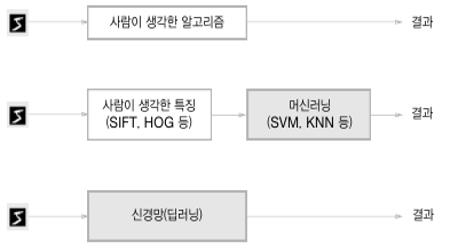

In [3]:
notebook_dp_image('./images/W4/img1.png', (450,250))

### 손실함수
#### 오차제곱합
**Sum Squares Error (SSE)**
$$
E = \frac{1}{2}\sum(y_k-t_k)^2
$$
where: 
- $y_k=\text{prediction}$
- $t_k=\text{truth/answer}$

가장 많이 쓰이고 비교적 단순/직관적

저번의 예시를 들자면 최종 레이어인 소프트맥스 함수의 결과에서 나오는 값이다. 파이썬에서는 `ndarray`으로 나오겠죠?

In [4]:
def sum_squares_error(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    return .5 * np.sum((y - t) ** 2)

In [5]:
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ])
y = np.array([0.1, 0.05, 0.6, 0, 0.05, 0.1, 0, 0.1, 0, 0, ])
sum_squares_error(y, t)

np.float64(0.09750000000000003)

### 교차 엔트로피 오차
**Cross Entropy Error (CEE)**
$$
E=-\sum\limits_{k}^{} t_k \log y_k
$$

note:
- $\log$의 지수는 자연로그(e)임!
- $t_k$는 one-hot encoding 되어있음.

/tmp/ipykernel_89576/2026410675.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x))


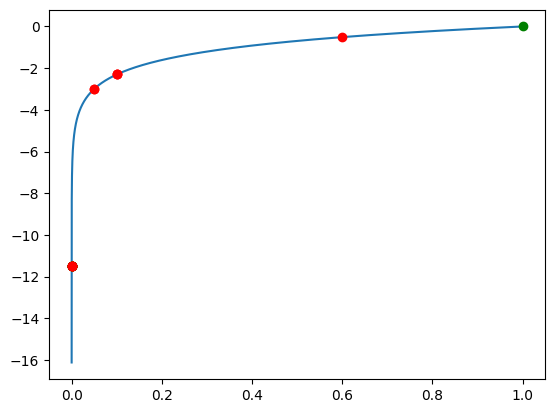

In [6]:
x = np.arange(0, 1, 1e-7)

eps = 1e-5 # zero div. error 해결용
t_ = t + eps
y_ = y + eps

plt.plot(x, np.log(x))
plt.plot(t_, np.log(t_), 'go')
plt.plot(y_, np.log(y_), 'ro')

plt.show()

In [7]:
def cross_entropy_error(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [8]:
cross_entropy_error(y, t)

np.float64(0.510825457099338)

---

### 미니배치 (mini batch)

실제 DL을 할 경우, 많은 양의 데이터를 상대로 검증해야할 수도 있음, 이때 여러 batch로 쪼개서 검증을 할수도 있는데 이 경우네 mini batch쓰는거임.

이런 경우 CCE도 이렇게 변함 (N은 총 sample의 개수)
$$
E=-\frac{1}{N}\sum\limits_{n}^{} \sum\limits_{k}^{} t_k \log y_k
$$

In [31]:
from tensorflow.keras.datasets import mnist

# MNIST data
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# flattening 및 정규화 거치기
x_train = x_train.reshape(-1, 28 * 28) / 255.
t_train = t_train.reshape(-1, 1)

(x_train.shape, t_train.shape)

((60000, 784), (60000, 1))

<u>(TF에 데이터도 같은 데이터라 TF통해 데이터 가져옴)</u>

위 결과에서 `t_train` 형태가 책에서 보기와 달리 6000*1인 이유는 one-hot encoding이 아니라 해당 정답 값을 가지고 있기 때문 (0  ~ 9)

In [10]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
batch_mask

array([26034, 28272, 41225, 56715, 14241,  8060, 17881, 54685, 17191,
       58726])

위 처럼 랜덤 선택을 통한 마스크 생성

In [11]:
# index based filtering
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

위의 batch CEE바탕으로 함수제작

아래는 one-hot encoding일 경우
(aka. categorical cross entrophy)

In [12]:
def cross_entropy_error(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = t.reshape(1, y.size)
    
    batch_size = y.shape[0]

    return -np.sum(t * np.log(y + 1e-7)) / batch_size


아래는 숫자 label(index)일 경우 
(aka. <u>sparse</u> categorical cross entropy)

In [13]:
def sp_cross_entropy_error(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = t.reshape(1, y.size)
    
    batch_size = y.shape[0]

    print(y)
    print()
    print(f'batch_size: {batch_size}\ny[{np.arange(batch_size)}, {t}]')
    [print(f'({x_}, {y_}) -> {y[x_, y_]}') for x_, y_ in zip(np.arange(batch_size), t)]
    print(f'result => {y[np.arange(batch_size), t]}')

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


꽤나 중요한 기법인 [Advanced Integer Indexing](https://www.tutorialspoint.com/numpy/numpy_advanced_indexing.htm)

syntax는 다음과 같음
- `target_array[List[row idx to select], List[col idx to select]]`
- `target_array[List[List[...], List[...]...], List[List[...], List[...]...]]` -> can be nested!!

결론적으로 `-np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size`에서...
- `np.arange(batch_size)` = 모든 행(샘플) 일단 선택
- `t` = 각 행(샘플)별 true한 index에 해당하는 값만 반환

In [14]:
y_small = np.array([
    [0.1, 0.8, 0.1],  # Predictions for sample 0
    [0.3, 0.4, 0.3],  # Predictions for sample 1
    [0.2, 0.2, 0.6]   # Predictions for sample 2
])

# For...
# sample 0, true class is 1;
# sample 1, true class is 0;
# sample 2, true class is 2.
t_small = np.array([1, 0, 2])

sp_cross_entropy_error(y_small, t_small)

[[0.1 0.8 0.1]
 [0.3 0.4 0.3]
 [0.2 0.2 0.6]]

batch_size: 3
y[[0 1 2], [1 0 2]]
(0, 1) -> 0.8
(1, 0) -> 0.3
(2, 2) -> 0.6
result => [0.8 0.3 0.6]


np.float64(0.645980451468738)

---

### 왜 손실함수를 쓰는가?

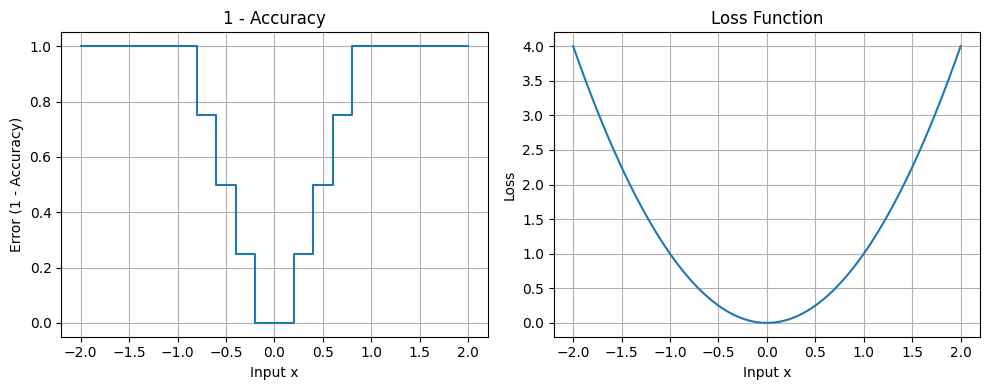

In [15]:
x = np.linspace(-2, 2, 400)

# 정확도 사용할 경우
conditions = [
    np.abs(x) < 0.2,
    (np.abs(x) >= 0.2) & (np.abs(x) < 0.4),
    (np.abs(x) >= 0.4) & (np.abs(x) < 0.6),
    (np.abs(x) >= 0.6) & (np.abs(x) < 0.8),
    np.abs(x) >= 0.8
]
values = [0, 0.25, 0.5, 0.75, 1]
y_accuracy = np.select(conditions, values, default=1)

# 손실함수를 사용할경우
y_loss = x**2

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.step(x, y_accuracy, where='mid')
plt.title("1 - Accuracy")
plt.xlabel("Input x")
plt.ylabel("Error (1 - Accuracy)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, y_loss)
plt.title("Loss Function")
plt.xlabel("Input x")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


인풋 `-2 < x < 2`인 함수에서 `x = 0`이 답이라고 가정하고 샘플 10개가 모여있다 가정하면 다음과 같은 그래프가 대충 나올 것이다.

왼쪽의 정확도를 사용한다면 샘플 하나씩 맞을때마다 오류가 떨어지며 계단모양이 되어서 x예측값이 선반 위에 있을 경우 모델은 어느방향으로 가야 성능 개선되는지 알 수 없음. 반면 오른쪽의 손실함수를 사용한 모델은 매끄럽게 내려가는 모양이라 미적해서 오류 최저값으로 경사하강 가능함! 

---

## 미분 할거리들

이 책에서는 '중심차분'/'중앙차분'으로 미분을 구함
$$
\frac{df(x)}{dx}=\lim_{k \to 0}\frac{f(x+h)-f(x-h)}{2h}
$$

In [16]:
def numerical_diff(f: callable, x: float) -> float:
    h = 1e-4
    return ( f(x + h) - f(x - h) ) / (2 * h)

간단한 식인 `func_1`을 미분해본다면:

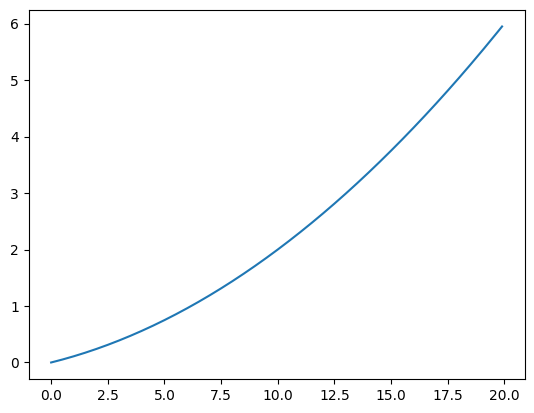

In [17]:
def func_1(x):
    return .01 * x ** 2 + .1 * x

x = np.arange(0.0, 20.0, 0.1)
plt.plot(x, func_1(x))

In [18]:
numerical_diff(func_1, 5)

0.1999999999990898

책에서의 2번째 미분 대상인
$$
f(x_0, x_1)=x_0^2+x_1^2
$$
을 확인해본다면:

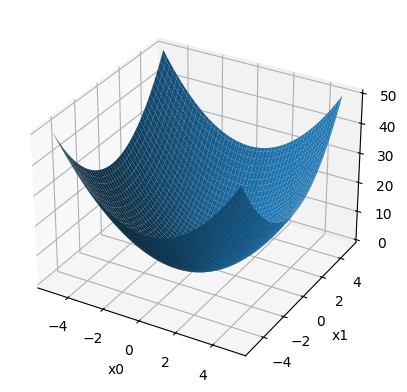

In [19]:
# from mpl_toolkits.mplot3d import Axes3D

x0 = np.linspace(-5, 5, 100)
x1 = np.linspace(-5, 5, 100)
x0, x1 = np.meshgrid(x0, x1)

y = x0**2 + x1**2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x0, x1, y)

ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('y')

plt.show()


note: `np.meshgrid`써야하는 이유

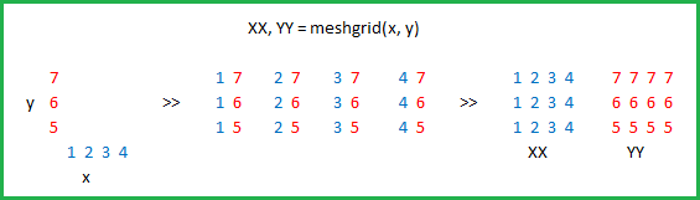

In [20]:
notebook_dp_image('./images/W4/img2.png', (700, 200))

In [21]:
def func_2(x):
    return x[0] ** 2 + x[1] ** 2

def numerical_gradient(f: callable, x: np.ndarray):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성

    for idx in range(x.size):
        tmp_val = x[idx]
    
        # f(x+h)
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원

    return grad

numerical_gradient(func_2, np.array([3.0, 4.0]))

array([6., 8.])

---

## 기울기

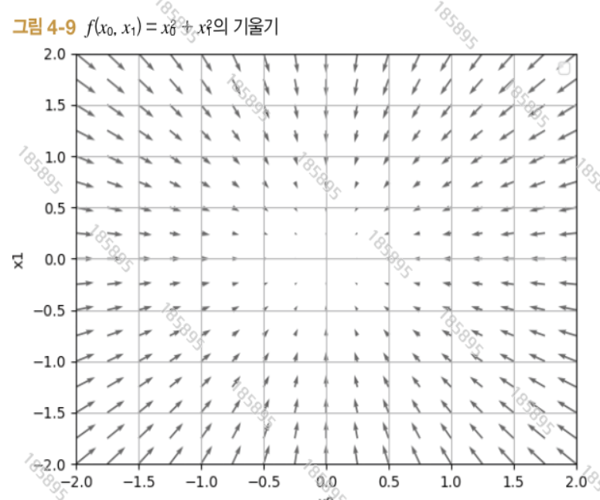

In [22]:
notebook_dp_image('./images/W4/img3.png', (600, 500))

위의 계단형 예시에서 봤듯이 오류가 최소가 되는 지점이 아닌데 기울기가 0 또는 0에 근접해버리는 경우가 있음. 다시말하자면 "안장점인줄 알았는데 고원이였다는", "gloabal minima가 아니라 local minima였다는"

이러게되면 global minima를 경사하강법 써서 찾는게 어려워짐.

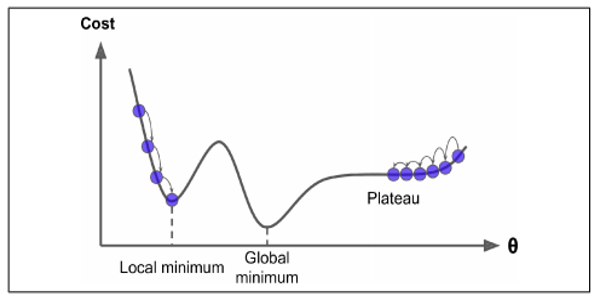

In [23]:
notebook_dp_image('./images/W4/img4.png', (600, 300))

**경사하강법 함수 만들어보기**

In [24]:
def gradient_descent(f: callable, 
                     lr=.1, 
                     step_num=100, 
                     init_x=np.array([5., 3.])):
    x = init_x.copy()  # 메모리 공유 방지
    x_d = list()

    for i in range(step_num):
        x_d.append(x.copy())
        grad = numerical_gradient(f, x)
        x -= lr * grad
    
    return x, x_d

final_x, x_d = gradient_descent(func_2)
_, x_d_lr = gradient_descent(func_2, lr = .7)
_, x_d_step = gradient_descent(func_2, step_num = 5)

final_x

array([1.01851799e-09, 6.11110793e-10])

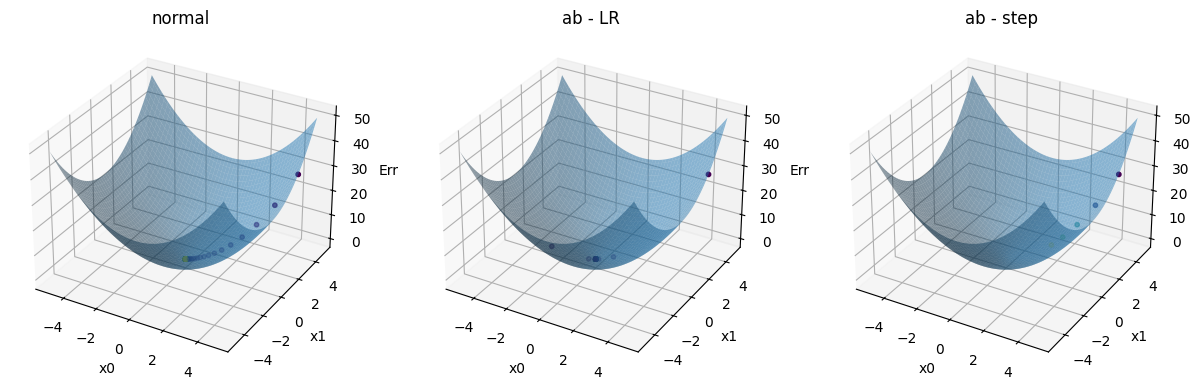

<Figure size 640x480 with 0 Axes>

In [25]:
x0 = np.linspace(-5, 5, 100)
x1 = np.linspace(-5, 5, 100)
x0, x1 = np.meshgrid(x0, x1)  # 3d 위해서

y = func_2(np.array([x0, x1]))
# y = x0**2 + x1**2

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

fig = plt.figure()
ax1.plot_surface(x0, x1, y, alpha=.5)
ax1.scatter([float(x[0]) for x in x_d], 
            [float(x[1]) for x in x_d], 
            [func_2(xs) for xs in x_d], 
            s = 10, 
            c = [i for i in range(len(x_d))])

ax1.set_xlabel('x0')
ax1.set_ylabel('x1')
ax1.set_zlabel('Err')
ax1.set_title('normal')


ax2.plot_surface(x0, x1, y, alpha=.5)
ax2.scatter([float(x[0]) for x in x_d_lr], 
            [float(x[1]) for x in x_d_lr], 
            [func_2(xs) for xs in x_d_lr], 
            s = 10, 
            c = [i for i in range(len(x_d_lr))])

ax2.set_xlabel('x0')
ax2.set_ylabel('x1')
ax2.set_zlabel('Err')
ax2.set_title('ab - LR')


ax3.plot_surface(x0, x1, y, alpha=.5)
ax3.scatter([float(x[0]) for x in x_d_step], 
            [float(x[1]) for x in x_d_step], 
            [func_2(xs) for xs in x_d_step], 
            s = 10, 
            c = [i for i in range(len(x_d_step))])

ax3.set_xlabel('x0')
ax3.set_ylabel('x1')
ax3.set_zlabel('Err')
ax3.set_title('ab - step')


plt.tight_layout()
plt.show()

위의 그래프는 (왼쪽부터) `이상적인 경사하강`, `lr가 큰 경우`, `step 횟수가 작은 경우`를 표현함.

- lr가 큰 경우에는 각 step별 이동거리가 커서 "왔다리갔다리"(oscillate)를 하는걸 볼 수 있다.
- step이 작은 경우에는 minima(minimum)에 도착하기전에 끝나버리는걸 볼 수 있다. (lr를 작게해도 같은 효과가 난다)


---

## 학습 (신경망) 알고리즘 구현해보기

다 쓰기에 오래걸리고, 내용은 사실상 같으니 TF로 구현함.

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model

In [27]:
# 전에 로드 했지만 혹시나 하니 처음부터~
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28 * 28).astype('float32') / 255.
x_test = x_test.reshape(-1, 28 * 28).astype('float32') / 255.

x_train.shape

(60000, 784)

In [32]:
two_layer_model = Sequential([
    Input((784,)),                  # 입력층
    Dense(100, activation='relu'),  # 은닉층 1번 (W1, b1)
    Dense(100, activation='relu'),  # 은닉층 2번 (W2, b2)
    Dense(10, activation='softmax') # 출력층 (소프트맥스)
])

# 컴파일 해서 훈련 준비
two_layer_model.compile(optimizer='adam', 
                        # ↓ 여기 주목! 원핫 했을때 안했을때 차이
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

**Batching 관련 유의점**

batching은 보통 각 data/t point별로 loss를 구해서 그 *평균*을 사용해서 gradient를 구한다.

하지만 책에서 확인해보면 loss종합을 CEE를 통해서 한다. y.size로 나누는게 안보이므로 loss의 합으로 종합하는 것으로 보임. 

관례적으로는 avg로 하긴 하는데 sum도 뭐 되기는 된다고 하는 듯...(TF도 avg사용)

```python
# 책에서 사용한 CEE
def cross_entropy_error(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))
```

In [29]:
# 피팅/훈련
two_layer_model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=100, # 얘가 차피 자동으로 batch processing해줌 ~
                    )

# 테스트/검증
loss, accuracy = two_layer_model.evaluate(x_test, y_test)
print("\n정확도:", accuracy)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8408 - loss: 0.5747
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9610 - loss: 0.1359
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9715 - loss: 0.0929
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9785 - loss: 0.0705
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9832 - loss: 0.0545
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9875 - loss: 0.0416
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9901 - loss: 0.0324
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9914 - loss: 0.0267
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9931 - loss: 0.0228
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9935 - loss: 0.0223
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.9666 - loss: 0.1181

정확도: 0.9725000262260437


**Batching 크기/방식에 따른 특장점들!**

- Batch_size == 1일 경우: *Stochastic*
- 1 < Batch_size <= (data_size / 2) 일 경우: *Mini-batch*
- Batch_size == data_size 일 경우: *Batch*

[ bigger batch | batch proc. <-> smaller batch | stochastic ]

컴퓨터 하드웨어에 따라 좌우됨: mem size & core count **vs.** CPU/GPU speed

데이터 분포에 따라 좌우됨: training 안정성 (minima 잘 찾기) **vs.** local minima / plateau 벗어나기 (탐험의 정도)

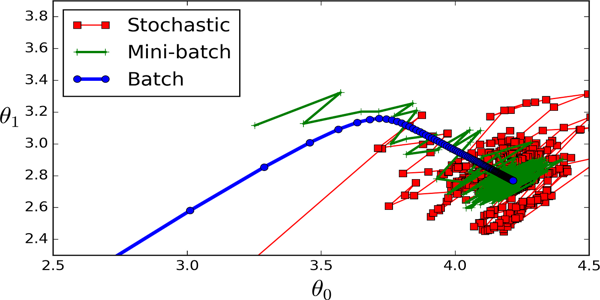

In [30]:
notebook_dp_image('./images/W4/img5.png', (600, 300))